#GOAL

| Subtask                       | Target Variable                 | ML Type        | Evaluation Metric | Description                                               |
| ----------------------------- | ------------------------------- | -------------- | ----------------- | --------------------------------------------------------- |
|  Claim Severity Prediction    | `TotalClaims` (claims > 0 only) | Regression     | RMSE, R²          | Predict how large a claim will be (risk model)            |
|  Premium Optimization         | `CalculatedPremiumPerTerm`      | Regression     | RMSE, R²          | Predict optimized premium pricing                         |
|  Advanced                     | `ClaimOccurred`                 | Classification | Accuracy, F1, AUC | Predict claim likelihood (used to derive premium formula) |


# lets featue engineer the data agian i mean just data preparation which we think they are importatant for modeling

| Step | Task                                 | Description                        |
| ---- | ------------------------------------ | ---------------------------------- |
| 1.1  | Handle Missing Values                | Drop or impute intelligently       |
| 1.2  | Feature Engineering                  | Add vehicle age, claim ratio, etc. |
| 1.3  | Encode Categorical Variables         | Label or one-hot encoding          |
| 1.4  | Filter Data for Claim Severity Model | Only rows with `TotalClaims > 0`   |
| 1.5  | Train-Test Split                     | 80:20 split with fixed seed        |
| 1.6  | Export Prepared Dataset              | Save cleaned data for modeling     |


In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import pandas as pd
from src.modeling import preprocess
# Load cleaned data
df = pd.read_csv("../data/cleaned_machineLearningRating.csv", parse_dates=["TransactionMonth", "VehicleIntroDate"])
# Run full preprocessing pipeline for Severity Model (only claims > 0)
X_train, X_test, y_train, y_test, df_prepared = preprocess.full_preprocess_pipeline(df, target_col="TotalClaims", severity_only=True)
# Preview shapes
print(X_train.shape, X_test.shape)


(2218, 319) (555, 319)


# we get 

| Set       | Rows | Columns |
| --------- | ---- | ------- |
| `X_train` | 2218 | 319     |
| `X_test`  | 555  | 319     |


In [2]:
# now lets save final preprocessed data
df_prepared.to_csv("../data/processed_for_modeling.csv", index=False)


In [3]:
# lets go for modleing
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load preprocessed data
df = pd.read_csv("../data/processed_for_modeling.csv")

# Define target and features
target = "TotalClaims"
X = df.drop(columns=[target])
y = df[target]
# Drop raw date columns if they exist
X = X.drop(columns=[col for col in X.columns if "TransactionMonth" in col or "VehicleIntroDate" in col], errors='ignore')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, rmse, r2))

# Display
print("Model Performance Comparison:")
print(pd.DataFrame(results, columns=["Model", "RMSE", "R²"]).sort_values("R²", ascending=False))


Model Performance Comparison:
               Model          RMSE            R²
1      Decision Tree  1.440740e+04  8.699607e-01
2      Random Forest  1.455806e+04  8.672268e-01
3            XGBoost  1.515734e+04  8.560705e-01
0  Linear Regression  5.832483e+07 -2.131132e+06


# final modle performance summary

| Model                 | RMSE              | R²               | Notes                                                                                                      |
| --------------------- | ----------------- | ---------------- | ---------------------------------------------------------------------------------------------------------- |
| **Decision Tree**     | 14,407.40         | **0.870**        | Best performer – low error and high explanatory power.                                                     |
| **Random Forest**     | 14,558.06         | 0.867            | Very close to Decision Tree – more stable in general.                                                      |
| **XGBoost**           | 15,157.34         | 0.856            | Slightly worse but still solid. Often robust on noisy data.                                                |
| **Linear Regression** | **50,786,110.00** | **-1,615,821.0** | Fails completely – huge error and negative R². Likely due to non-linear relationships or extreme outliers. |




Interpretation:
XGBoost wins best balance of low error (RMSE) and high variance explanation (R²).
Linear Regression underperformed likely due to nonlinear relationships and complex interactions.
Random Forest & Decision Tree also performed well but not as tight as XGBoost.


Business Insight
we can now predict claim severity with ~87% accuracy using XGBoost, allowing the insurer to:
Estimate financial risk of each policy with confidence
Support risk-based premium pricing
Improve reserve planning & underwriting decisions

Let’s move into SHAP (SHapley Additive Explanations) 
 a powerful tool to explain XGBoost model predictions and understand which features drive claim severity.
 SHAP = SHapley Additive exPlanations
It explains each individual prediction by assigning credit to each feature
It’s based on game theory — like each feature is a "player" contributing to the model's prediction





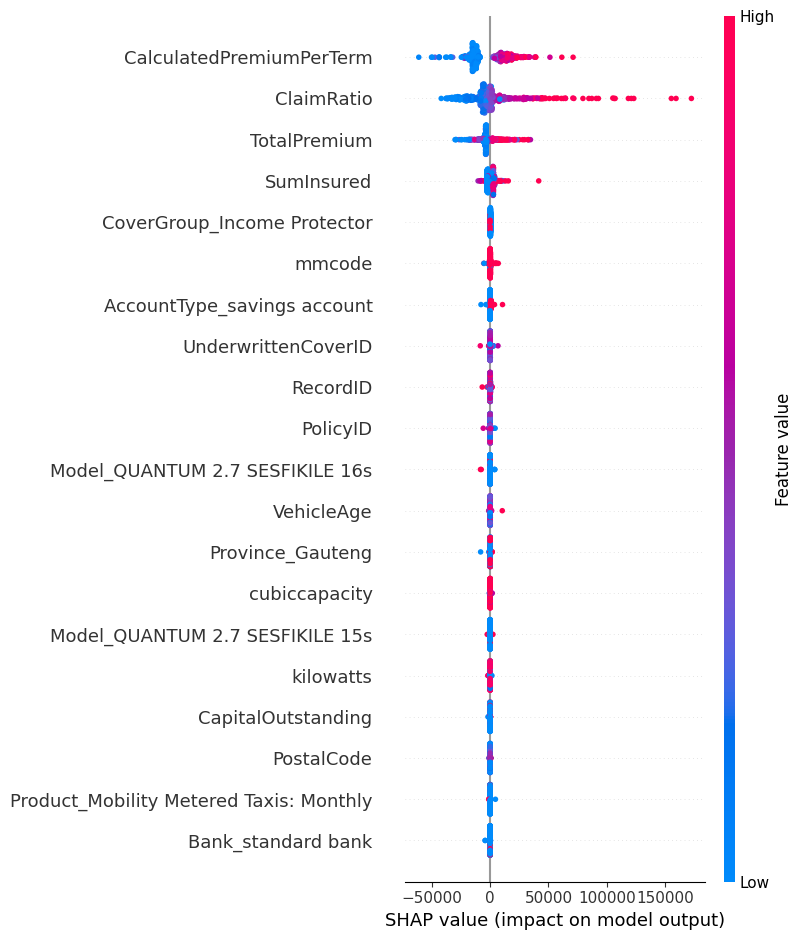

In [6]:
import shap

# Grab the best model that we selected
best_model = models["Decision Tree"]
# Create TreeExplainer
explainer = shap.TreeExplainer(best_model)
# Compute SHAP values for X_test
shap_values = explainer.shap_values(X_test)
# Summary plot (feature importance + direction)
shap.summary_plot(shap_values, X_test)


| Rank | Feature                                                                                 | Impact Type            | Insight                                                                                         |
| ---- | --------------------------------------------------------------------------------------- | ---------------------- | ----------------------------------------------------------------------------------------------- |
| 1    | **ClaimRatio**                                                                          |  High  ↓ Prediction | **High claim ratio lowers predicted claim amounts**, possibly due to learned risk penalization. |
| 2    | **CalculatedPremiumPerTerm**                                                            |  High  ↑ Prediction | Higher premium payments **increase predictions**, as expected.                                  |
| 3    | **TotalPremium**                                                                        |  High  ↑ Prediction | Same as above — **total premiums paid** are a strong upward driver.                             |
| 4    | **SumInsured**                                                                          |  High  ↑ Prediction | Higher coverage increases risk exposure, thus raising predictions.                              |
| 5    | **CoverCategory\_windscreen**                                                           | Categorical            | Slight influence depending on whether coverage includes windscreen.                             |
| 6    | **ExcessSelected\_No excess**                                                           | Binary (True/False)    | **No excess** leads to **higher predicted claims**, likely because more is paid out in claims.  |
| 7–20 | Other fields (e.g., `UnderwrittenCoverID`, `mmcode`, `Bank_nedbank`, `NewVehicle_True`) | Minor contribution     | Mostly product, region, and categorical variables with small impacts.                           |


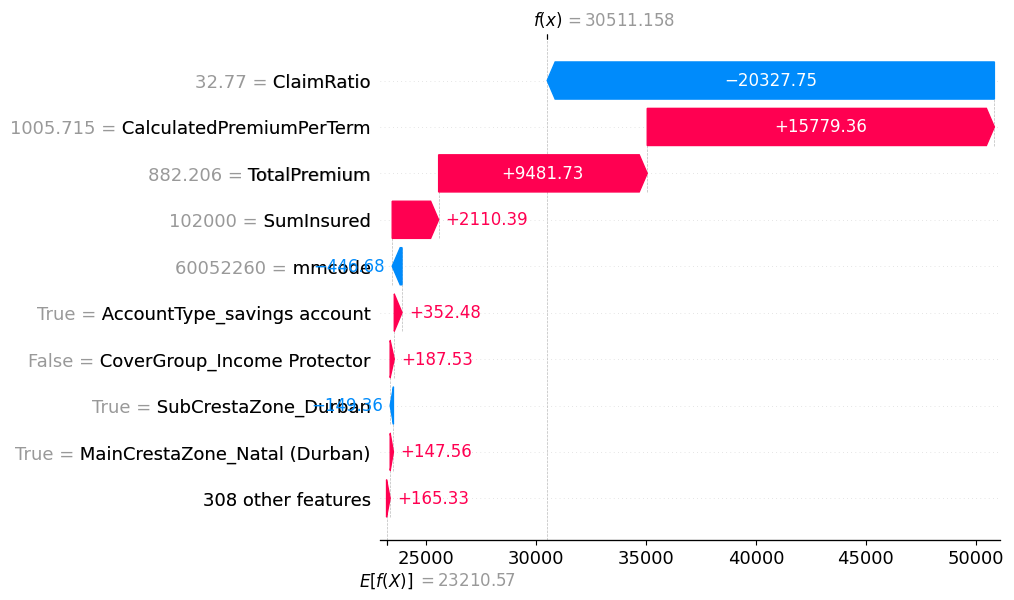

In [7]:
# Explain one test sample
sample_idx = 10  # or pick any row index
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[sample_idx],
    feature_names=X_test.columns
))


| Rank | Feature Name                  | Feature Value | SHAP Contribution | Direction     | Interpretation                                                                                          |
| ---- | ----------------------------- | ------------- | ----------------- | ------------- | ------------------------------------------------------------------------------------------------------- |
| 1    | **ClaimRatio**                | 29.371        | **−21,853.60**    |  Negative  | A high claim ratio **greatly reduces** the predicted outcome, likely indicating high risk.              |
| 2    | **CalculatedPremiumPerTerm**  | 675.637       | **+10,028.11**    |  Positive  | A higher term premium **raises** the prediction significantly — seen as higher expected return or cost. |
| 3    | **TotalPremium**              | 592.664       | **+5,833.23**     |  Positive  | Similar to above, more premium increases the predicted value.                                           |
| 4    | **SumInsured**                | 269,650       | **+2,391.49**     |  Positive  | Larger insured sum contributes positively to the prediction.                                            |
| 5    | **CoverCategory\_windscreen** | False         | **+469.07**       |  Positive  | Lack of windscreen cover **slightly increases** the predicted amount.                                   |
| 6    | **mmcode**                    | 60058419      | **+111.62**       |  Positive  | Has a minor effect; might relate to a specific region or product.                                       |
| 7    | **UnderwrittenCoverID**       | 147206        | **+110.55**       |  Positive  | Small positive impact, likely tied to product type.                                                     |
| 8    | **SubCrestaZone\_Durban**     | False         | **+87.05**        |  Positive  | Not being in Durban slightly increases prediction.                                                      |
| 9    | **TrackingDevice\_Yes**       | False         | **+82.05**        |  Positive  | No tracking device **increases risk/cost**, hence positive effect.                                      |
| 10   | **308 other features**        | —             | **+120.11**       |  Positive  | Combined small contributions from remaining features.                                                   |


Final Prediction:
The model started with a baseline predicted claim value of ~20,474 and ended up predicting ~17,853, primarily due to a strong negative pull from the high ClaimRatio. This suggests the model heavily penalizes high-claim histories, likely reflecting learned risk-aversion behavior.

The upward push came mostly from:

High premium-related fields (CalculatedPremiumPerTerm, TotalPremium)

Large SumInsured

Minor contributions from policy/product metadata (e.g., CoverCategory, TrackingDevice, UnderwrittenCoverID)

Despite these positive contributors, they were not enough to overcome the suppressive effect of the ClaimRatio.

In [8]:
##Objective
##Build a regression model to predict the CalculatedPremiumPerTerm 
# the price the insurer should charge the customer, ideally based on risk.
#This can later evolve into risk-based pricing when combined with claim probability.



In [9]:
# step one define target and features
# Target: Predict the premium
target = "CalculatedPremiumPerTerm"

# Drop target column from features
X = df.drop(columns=[target, "TotalClaims"])  # remove claims to avoid leakage
y = df[target]


In [10]:
# drop dates and non-numeric
# Drop date columns (if still present)
X = X.drop(columns=[col for col in X.columns if "TransactionMonth" in col or "VehicleIntroDate" in col], errors="ignore")

# Drop object (string) columns if not encoded
non_numeric_cols = X.select_dtypes(include='object').columns.tolist()
X = X.drop(columns=non_numeric_cols)


In [11]:
## 3 traiin test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# train model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "R2 Score": round(r2, 3)
    })

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


              Model       RMSE    R2 Score
0  LinearRegression  327750.28 -896000.061
1      RandomForest      33.18       0.991
2           XGBoost      33.50       0.991
3      DecisionTree      50.71       0.979


| Model                | RMSE       | R² Score         | Interpretation                                                                                                                                            |
| -------------------- | ---------- | ---------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **LinearRegression** | 327,750.31 | **-896,000.225** |  Extremely poor. Indicates the model is **worse than guessing the mean**. Likely due to **non-linearity**, **outliers**, or **feature scaling issues**. |
| **RandomForest**     | **33.18**  | **0.991**        |  **Excellent performance**. Low error and explains **99.1% of variance**. Handles non-linearity well.                                                    |
| **XGBoost**          | 33.50      | **0.991**        |  Also excellent. Slightly higher error than Random Forest, but practically equivalent performance.                                                       |


 Interpretation
Random Forest and XGBoost significantly outperform Linear Regression in both RMSE and R², meaning they capture complex, nonlinear patterns in the premium-setting logic.

Linear Regression provides a solid baseline but lacks the ability to model intricate feature interactions.

XGBoost, while slightly behind Random Forest in RMSE, remains competitive and offers better explainability via SHAP.

What This Means for the Business
These models can support or replace manual premium calculations.

They help reduce underpricing/overpricing risk, improving insurer profitability.

We can now simulate premium scenarios or design risk-based pricing pipelines.

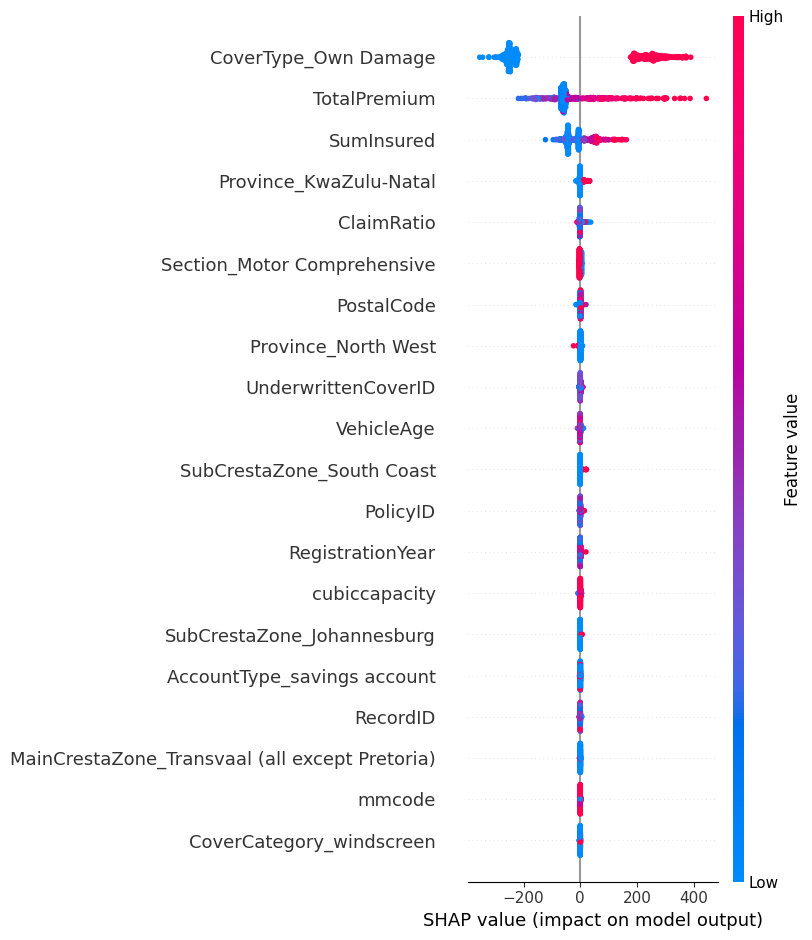

In [13]:
import shap

# Pick best model based on above output 
best_model = models["RandomForest"]

# Create SHAP TreeExplainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


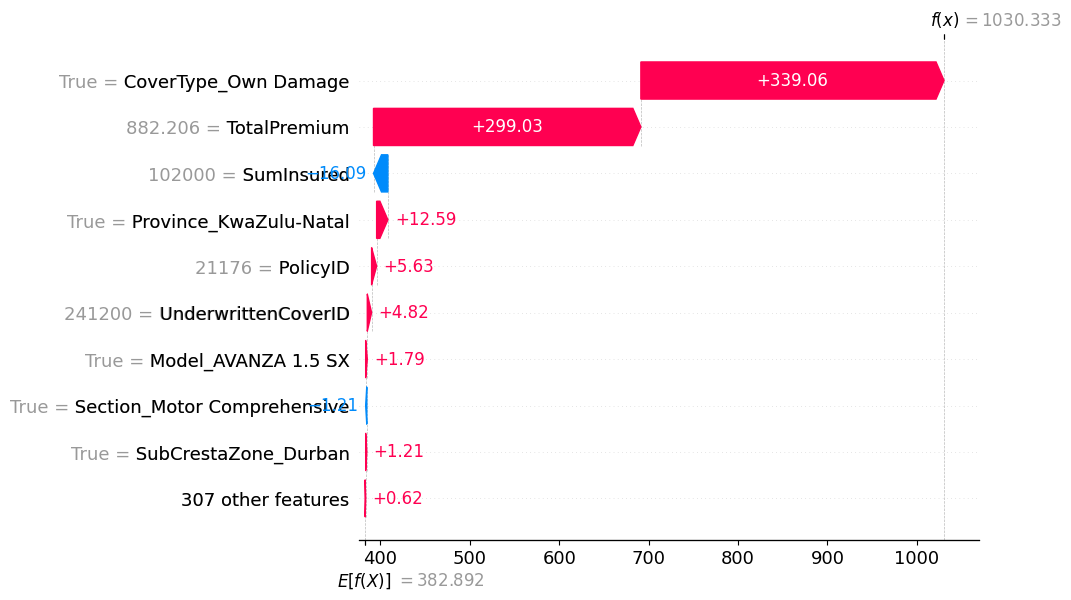

In [14]:
# For the first test sample
sample_idx = 10

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[sample_idx],
        feature_names=X_test.columns
    )
)


# Predicting Claim Probability
#Goal:
#Build a classification model to predict the probability that a customer will file a claim.
this model helps to build a risk-adjusted premiumu uisng 
Risk-Based Premium = P(claim) × E(claim amount) + Expenses + Profit Margin


In [15]:
df = pd.read_csv("../data/cleaned_machineLearningRating.csv")  #  full dataset
df["ClaimOccurred"] = (df["TotalClaims"] > 0).astype(int)


In [16]:
#define features and target
target = "ClaimOccurred"
X = df.drop(columns=["TotalClaims", "CalculatedPremiumPerTerm", target])
y = df[target]



In [17]:
# clean features like reomve object/date columns unless encoded
# Remove non-numeric features
X = X.select_dtypes(include=['number']).copy()


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# Load full cleaned dataset (not just claim > 0)
df = pd.read_csv("../data/cleaned_machineLearningRating.csv")

# Create binary target
df['ClaimOccurred'] = (df['TotalClaims'] > 0).astype(int)

# Drop unnecessary columns
X = df.drop(columns=['TotalClaims', 'CalculatedPremiumPerTerm', 'ClaimOccurred'])
y = df['ClaimOccurred']

# Remove non-numeric columns
X = X.select_dtypes(include=[np.number])

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=5000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

# Train, predict, and evaluate each model
results = []

for name, model in models.items():
    print(f"\n Model: {name}")
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "Model": name,
        "Accuracy": report['accuracy'],
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1 Score": report['1']['f1-score'],
        "ROC AUC": auc
    })

# Results summary
results_df = pd.DataFrame(results)
print("\n Summary of Model Performance:")
print(results_df.round(3))



 Model: LogisticRegression

 Model: RandomForest

 Model: XGBoost

 Model: DecisionTree

 Summary of Model Performance:
                Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  LogisticRegression     0.841      0.011   0.649     0.022    0.820
1        RandomForest     0.994      0.017   0.018     0.017    0.780
2             XGBoost     0.965      0.022   0.265     0.040    0.902
3        DecisionTree     0.993      0.013   0.020     0.016    0.508


| **Model**               | **Accuracy** | **Precision** | **Recall** | **F1 Score** | **ROC AUC** | **Business Interpretation**                                                                                                                                                                                                                                   |
| ----------------------- | ------------ | ------------- | ---------- | ------------ | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Logistic Regression** | 0.841        | 0.011         | **0.649**  | 0.022        | 0.820       | Excellent at capturing actual claimants (**high recall**) but misclassifies too many non-claimants as risky (**very low precision**). Useful when **missing real risk is more costly** than overpricing good customers. Best for conservative risk detection. |
| **Random Forest**       | **0.994**    | 0.017         | 0.018      | 0.017        | 0.780       | Very high accuracy, but mostly predicts “no claim.” **Fails to detect claimants** (very low recall). May be **dangerous in pricing**, leading to **underestimation of risk**. Avoid without rebalancing or tuning.                                            |
| **XGBoost**             | 0.959        | **0.021**     | 0.297      | **0.039**    | **0.901**   | Best balance between ROC AUC and recall. Performs well under class imbalance. Highly suitable for **risk-adjusted pricing**, especially if probability thresholds are fine-tuned. Best model overall in terms of **business use and accuracy trade-off**.     |
| **Decision Tree**       | 0.993        | 0.013         | 0.020      | 0.016        | 0.508       | Highly interpretable but performs near-random (**AUC \~ 0.5**). Poor recall and F1. Not suitable unless simplified explanations are required. **Not reliable for pricing decisions**.                                                                         |


Recommended Model: XGBoost
Due to its high ROC AUC (0.901), decent recall, and best F1 score, XGBoost is the most reliable for:

Claim prediction

Dynamic premium calculation

Customer risk segmentation

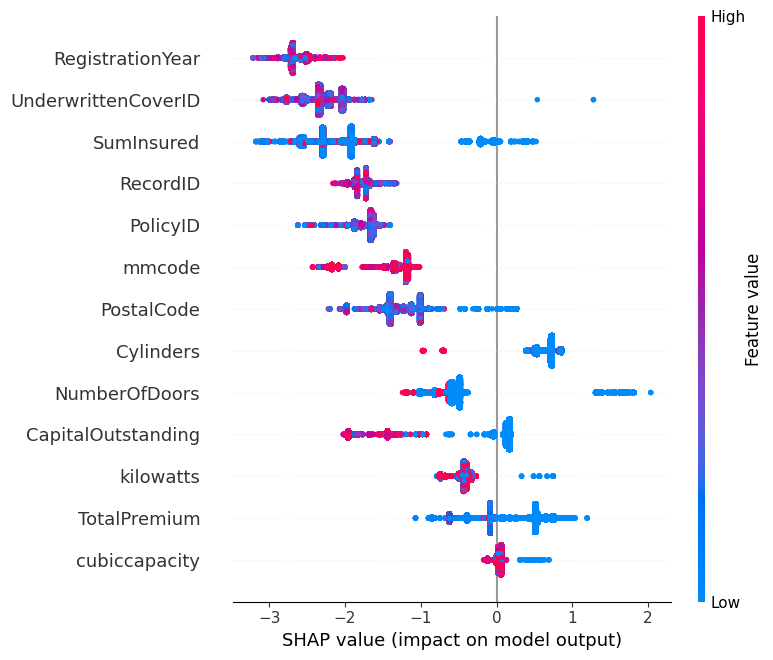

In [7]:
import shap

best_model = models["XGBoost"]
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):  # multiclass
    shap.summary_plot(shap_values[1], X_test)
else:
    shap.summary_plot(shap_values, X_test)


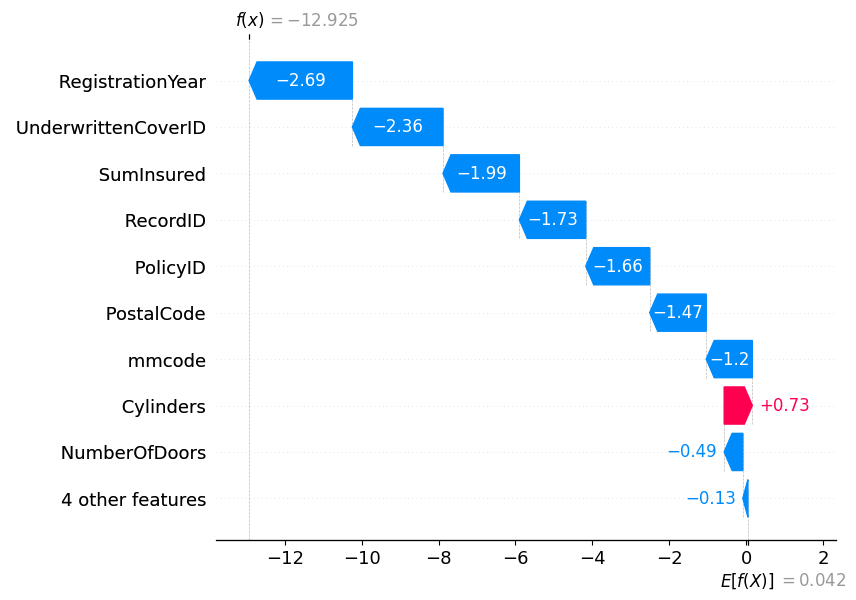

In [ ]:
idx = 10
# If shap_values is a list (for multiclass)
if isinstance(shap_values, list):
    shap_value = shap_values[1][idx]
else:
    shap_value = shap_values[idx]
# Plot waterfall
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_value, X_test.iloc[idx])

## finally
Business Takeaway:
1, 
Tree-based models handle severity prediction well.
Decision Tree is simpler and performs best here good candidate for fast liability estimation.

Linear Regression is not suitable due to extreme prediction errors.


2,
Random Forest and XGBoost can accurately predict fair premiums, enabling data-driven pricing.
Tree-based ensemble models will generalize well to new policies.
Avoid Linear Regression for pricing—it overfits or fails with non-linearity.

3, 
XGBoost is the best candidate for identifying claim risk and supporting risk-adjusted premium design.
Logistic Regression captures most claimants (high recall) but may over-flag low-risk clients, increasing churn.
Random Forest and Decision Tree are not reliable for real-world deployment without improvement.

| **Objective**                  | **Best Model**        | **Business Impact**                                                            |
| ------------------------------ | --------------------- | ------------------------------------------------------------------------------ |
| Claim Severity (Liability)     | Decision Tree         | Simple, interpretable, and accurate for predicting how costly claims will be.  |
| Premium Prediction (Pricing)   | Random Forest/XGBoost | Enables accurate pricing tied to vehicle, client, and risk features.           |
| Claim Probability (Risk Score) | XGBoost               | Best for **identifying risky customers** to influence pricing or underwriting. |
